In [1]:
# get all of the data
# and format it in a workable way

import util
import os

data = util.read_csv(os.path.join('.', 'tweets.csv'))
parsed_data = util.parse(data)
polar_neutral_data = util.polar_neutral_split(parsed_data)
pos_neg_data = util.pos_neg_split(parsed_data)
chopped_data = util.chop_data(parsed_data)

all_X, all_y = util.generate_x_y(parsed_data)
polar_neutral_X, polar_neutral_y = util.generate_x_y(polar_neutral_data)
pos_neg_X, pos_neg_y = util.generate_x_y(pos_neg_data)
chopped_X, chopped_y = util.generate_x_y(chopped_data)

print('Data ready to go')

Data ready to go


In [2]:
# find baseline accuracy based on existing modules
# more specifically textblob and vaderSentiment
# start with textblob

from textblob import TextBlob

textblob_results = [TextBlob(x).sentiment for x in all_X]
textblob_y = []
for result in textblob_results:
    if result.polarity < -1/3:
        textblob_y.append(-1)
    elif result.polarity < 1/3:
        textblob_y.append(0)
    else:
        textblob_y.append(1)

textblob_acc = util.get_accuracy(all_y, textblob_y)
print('textblob accuracy: %f' % textblob_acc)

textblob accuracy: 0.333538


In [3]:
# now move on to vader

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

vader_results = [analyzer.polarity_scores(x) for x in all_X]
vader_y = []
for result in vader_results:
    if result['compound'] <= -0.05:
        vader_y.append(-1)
    elif result['compound'] < 0.05:
        vader_y.append(0)
    else:
        vader_y.append(1)

vader_acc = util.get_accuracy(all_y, vader_y)
print('vaderSentiment accuracy: %f' % vader_acc)

vaderSentiment accuracy: 0.542828


In [2]:
# generate, fit, and predict on the full data with a svm classifier for future use

classifier = util.generate_classifier('svm')

classifier.fit(all_X, all_y)
pred_y = classifier.predict(all_X)

print('all_X classifier and predictions ready to go')

all_X classifier and predictions ready to go


In [4]:
# now let's create our own sentiment analyzer
# first, try it on the whole dataset

train_acc, test_acc = util.cross_validate(10, True, 'svm', all_X, all_y)
    
print('all_x train acc: %f, all_x test acc: %f' % (train_acc, test_acc))

all_x train acc: 0.914769, all_x test acc: 0.802254


In [5]:
# second, focus on just the polar-neutral classification

train_acc, test_acc = util.cross_validate(10, True, 'svm', polar_neutral_X, polar_neutral_y)

print('polar-neutral train acc: %f, polar-neutral test acc: %f' % (train_acc, test_acc))

polar-neutral train acc: 0.924142, polar-neutral test acc: 0.846516


In [6]:
# third, focus on just the pos-neg classification

train_acc, test_acc = util.cross_validate(10, True, 'svm', pos_neg_X, pos_neg_y)

print('pos-neg train acc: %f, pos-neg test acc: %f' % (train_acc, test_acc))

pos-neg train acc: 0.973361, pos-neg test acc: 0.925226


In [4]:
# find which samples the classifier struggled with

clf_errors = util.find_errors(parsed_data, all_y, pred_y)

print('%d errors out of %d samples (%f)' %
     (len(clf_errors), len(all_y), len(clf_errors) / len(all_y)))
print()

for row in clf_errors:
    print('%s' % (row[1]))
    print('true: %d, predicted: %d, confidence: %f' % (row[2], row[3], row[4]))
    print()

1274 errors out of 14640 samples (0.087022)

@VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!
true: -1, predicted: 0, confidence: 1.000000

@VirginAmerica plz help me win my bid upgrade for my flight 2/27 LAX---&gt;SEA!!!  🍷👍💺✈️
true: 0, predicted: 1, confidence: 1.000000

@VirginAmerica I have an unused ticket but moved to a new city where you don't fly. How can I fly with you before it expires? #travelhelp
true: 0, predicted: -1, confidence: 0.657800

@VirginAmerica Is flight 769 on it's way? Was supposed to take off 30 minutes ago. Website still shows "On Time" not "In Flight". Thanks.
true: 0, predicted: -1, confidence: 0.676400

@VirginAmerica @ladygaga @carrieunderwood Julie Andrews all the way though @ladygaga was very impressive! NO to @Carrieunderwood
true: 1, predicted: 0, confidence: 0.657000

@VirginAmerica you know it. Need it on my spotify stat #guiltypleasures
true: 1, predicted: 0, confidence:

true: 0, predicted: -1, confidence: 0.381900

First base already? I like your style @JetBlue
true: 1, predicted: 0, confidence: 1.000000

@JetBlue Does your home airport not count in the badge system? My TB account says 2 flights but I've taken 3 this year.
true: 0, predicted: -1, confidence: 0.680500

@JetBlue I know where you guys jet! LOL, but if you love me so much, help a brother out :) Hot weather, great nightlife, 2-3 hour flight
true: 0, predicted: 1, confidence: 1.000000

@JetBlue I applied for a job at PDW where could I go for follow up. I'd really love the job #ilovejetblue
true: 0, predicted: 1, confidence: 0.637700

@JetBlue i'm getting info from the website, but needing to check it and the alerts would be much more beneficial.
true: 0, predicted: -1, confidence: 0.666700

@JetBlue Haha. I figured that. I was meaning there's no return flights out of Charlotte. It's like N/A for a week plus
true: 0, predicted: -1, confidence: 0.660200

@JetBlue Well, I try! See you soon!! @

In [9]:
# see what type of classifications the classifier struggled with

zbp, zbn, pbn, pbz, nbp, nbz = util.get_error_metrics(all_y, pred_y)
total = zbp + zbn + pbn + pbz + nbp + nbz

print('true 0, pred 1: %f' % (zbp / total))
print('true 0, pred -1: %f' % (zbn / total))
print('true 1, pred -1: %f' % (pbn / total))
print('true 1, pred 0: %f' % (pbz / total))
print('true -1, pred 1: %f' % (nbp / total))
print('true -1, pred 0: %f' % (nbz / total))

true 0, pred 1: 0.091837
true 0, pred -1: 0.473312
true 1, pred -1: 0.181319
true 1, pred 0: 0.082418
true -1, pred 1: 0.043956
true -1, pred 0: 0.127159


General data
Mean confidence: 0.900169, Median confidence: 1.000000


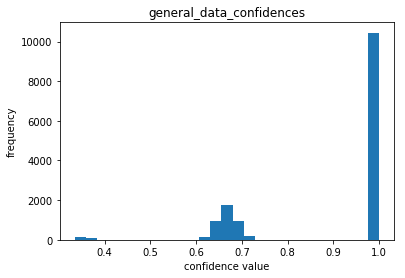

<Figure size 432x288 with 0 Axes>

In [3]:
# show confidences of general data

import numpy as np

confidences = [row[1] for row in parsed_data]
print('General data')
print('Mean confidence: %f, Median confidence: %f' %
     (np.mean(confidences), np.median(confidences)))
util.make_histogram(
    'general_data_confidences', 'confidence value', 'frequency', confidences)

With our classifier
Mean confidence: 0.751568, Median confidence: 0.677650


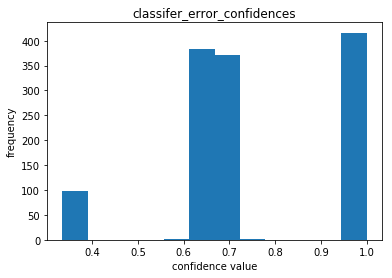

<Figure size 432x288 with 0 Axes>

In [4]:
# show confidences of the errors with our classifications

confidences = util.check_confidence(parsed_data, all_y, pred_y)
print('With our classifier')
print('Mean confidence: %f, Median confidence: %f' %
     (np.mean(confidences), np.median(confidences)))
util.make_histogram(
    'classifer_error_confidences', 'confidence value', 'frequency', confidences)

In [1]:
# general data analysis on sentiment distribution

pos = 0
neutral = 0
neg = 0

for row in parsed_data:
    if row[0] == 1:
        pos += 1
    elif row[0] == 0:
        neutral += 1
    elif row[0] == -1:
        neg += 1

total = pos + neutral + neg
print('pos: %f, neutral: %f, neg: %f' % (pos/total, neutral/total, neg/total))

NameError: name 'parsed_data' is not defined

In [5]:
# use a regressor instead of a classifier to see what the svm struggles with

regressor = util.generate_regressor('svm')

regressor.fit(all_X, all_y)
regressed_y = regressor.predict(all_X)

print('all_X regressor and predictions ready to go')

all_X regressor and predictions ready to go


In [9]:
# find best threshold values

best_accuracy = 0
best_thresholds = [1, -1]

i = 1
while i > -1:
    j = -1
    while j < i:
        thresholds = [j, i]
        classified_y = util.regression_to_classification(thresholds, regressed_y)
        accuracy = util.get_accuracy(all_y, classified_y)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_thresholds = [j, i]
        j += 0.01
    i -= 0.01

print('Best accuracy: %f' % best_accuracy)
print('Best thresholds: %s' % best_thresholds)

Best accuracy: 0.899249
Best thresholds: [-0.4099999999999995, 0.11999999999999923]


In [10]:
# check regressor on cross validation with best thresholds

thresholds = [-0.41, 0.12]
train_acc, test_acc = util.cross_validate(10, False, 'svm', all_X, all_y, thresholds)
    
print('all_x train acc: %f, all_x test acc: %f' % (train_acc, test_acc))

all_x train acc: 0.901806, all_x test acc: 0.742077


In [10]:
# checks the errors of the classifiers against the results of the regressor
# for reference, best bounds were found to be -0.41 and 0.12

for error in clf_errors:
    index = error[0]
    print(error[1])
    print('true: %d, predicted: %d, regression: %f, confidence: %f' %
         (error[2], error[3], regressed_y[index], error[4]))
    print()

@VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!
true: -1, predicted: 0, regression: -0.485201, confidence: 1.000000

@VirginAmerica plz help me win my bid upgrade for my flight 2/27 LAX---&gt;SEA!!!  🍷👍💺✈️
true: 0, predicted: 1, regression: 0.159485, confidence: 1.000000

@VirginAmerica I have an unused ticket but moved to a new city where you don't fly. How can I fly with you before it expires? #travelhelp
true: 0, predicted: -1, regression: -0.386913, confidence: 0.657800

@VirginAmerica Is flight 769 on it's way? Was supposed to take off 30 minutes ago. Website still shows "On Time" not "In Flight". Thanks.
true: 0, predicted: -1, regression: -0.599026, confidence: 0.676400

@VirginAmerica @ladygaga @carrieunderwood Julie Andrews all the way though @ladygaga was very impressive! NO to @Carrieunderwood
true: 1, predicted: 0, regression: 0.039190, confidence: 0.657000

@VirginAmerica you know it. Need it on

true: 0, predicted: -1, regression: -0.384015, confidence: 0.689400

@USAirways @AmericanAir shout out to Diane at EYW for helping get us home today instead of tomorrow (even if a little Late Flight!)
true: 1, predicted: -1, regression: 0.284670, confidence: 0.677400

@USAirways It's 838. We boarded and we are waiting now to take off, hopefully.
true: 0, predicted: -1, regression: -0.421807, confidence: 1.000000

@USAirways US 728. Refuel; we've sat for so long. Pilot announces where the truck is. "Look, over there to the left!" Actual announcement.
true: 0, predicted: -1, regression: -0.602362, confidence: 0.618700

@USAirways US 728 Wait, now a gate opened. Back we go. (Good, maybe we can get off.)
true: 0, predicted: -1, regression: -0.190989, confidence: 0.701500

@USAirways US 728 stated their issues as: kept plane on ground to allow connecting passengers from other flight to board. Fine. Understand.
true: 0, predicted: -1, regression: -0.773326, confidence: 0.672900

@usairways r

In [2]:
# chop the data to make the data proportions balanced and train a classifier on it

chopped_classifier = util.generate_classifier('svm')

chopped_classifier.fit(chopped_X, chopped_y)
chopped_y_pred = chopped_classifier.predict(chopped_X)

print('chopped classifier and predictions ready to go')

chopped classifier and predictions ready to go


In [4]:
# get the accuracy of the trained chopped classifier on all data

chopped_ally_pred = chopped_classifier.predict(all_X)

print('chopped accuracy on all data: %f' % util.get_accuracy(all_y, chopped_ally_pred))

chopped accuracy on all data: 0.837842


In [5]:
# run a cross validation on the chopped data

train_acc, test_acc = util.cross_validate(10, True, 'svm', chopped_X, chopped_y)
    
print('chopped train acc: %f, chopped test acc: %f' % (train_acc, test_acc))

chopped train acc: 0.932728, chopped test acc: 0.801098


In [6]:
# see what type of classifications the chopped classifier struggled with for chopped data

zbp, zbn, pbn, pbz, nbp, nbz = util.get_error_metrics(chopped_y, chopped_y_pred)
total = zbp + zbn + pbn + pbz + nbp + nbz

print('true 0, pred 1: %f' % (zbp / total))
print('true 0, pred -1: %f' % (zbn / total))
print('true 1, pred -1: %f' % (pbn / total))
print('true 1, pred 0: %f' % (pbz / total))
print('true -1, pred 1: %f' % (nbp / total))
print('true -1, pred 0: %f' % (nbz / total))

true 0, pred 1: 0.171779
true 0, pred -1: 0.235174
true 1, pred -1: 0.147239
true 1, pred 0: 0.169734
true -1, pred 1: 0.075665
true -1, pred 0: 0.200409


In [7]:
# see what type of classifications the chopped classifier struggled with for all data

zbp, zbn, pbn, pbz, nbp, nbz = util.get_error_metrics(all_y, chopped_ally_pred)
total = zbp + zbn + pbn + pbz + nbp + nbz

print('true 0, pred 1: %f' % (zbp / total))
print('true 0, pred -1: %f' % (zbn / total))
print('true 1, pred -1: %f' % (pbn / total))
print('true 1, pred 0: %f' % (pbz / total))
print('true -1, pred 1: %f' % (nbp / total))
print('true -1, pred 0: %f' % (nbz / total))

true 0, pred 1: 0.116681
true 0, pred -1: 0.169334
true 1, pred -1: 0.030329
true 1, pred 0: 0.034962
true -1, pred 1: 0.204297
true -1, pred 0: 0.444398


In [27]:
# see the classification of a given sentence

sentence = 'not great flight'

prediction = classifier.predict([sentence])

print(sentence)
print('prediction: %d' % prediction)

not great flight
prediction: 1


In [28]:
# see the regression of a given sentence
# for reference, best bounds were found to be -0.41 and 0.12

sentence = 'not great flight'

prediction = regressor.predict([sentence])

print(sentence)
print('prediction: %f' % prediction)

not great flight
prediction: 0.534091
